Aim of the project:
- To recommend content to the users based on their interactions with the OTT platform.
- This helps them get into a habit of regularly visiting the platform and engaging with the content, which in turn helps the platform to increase the user engagement, and hence the user base.
- This finally helps with user retention and user satisfaction.
- If recommendations are not possible, we need to recommend the Top 10 movies with the most ratings.

### Package installation and import

In [16]:
# %pip install numpy pandas scikit-learn

In [17]:
import os

# import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# np.random.seed(42)

### Data collection

In [18]:
datasets_dir = 'datasets'
dataset_foldername = 'ml-latest-small'

zip_file = os.path.join(datasets_dir, dataset_foldername + '.zip')
extracted_folder = zip_file.replace('.zip', '')
ratings_file = os.path.join(extracted_folder, 'ratings.csv')
movies_file = os.path.join(extracted_folder, 'movies.csv')
user_tags_file = os.path.join(extracted_folder, 'tags.csv')


# Create 'datasets' directory if it doesn't exist
if not os.path.exists(datasets_dir):
	os.makedirs(datasets_dir)


# if the dataset files don't exist
if any(not os.path.exists(file) for file in [ratings_file, movies_file, user_tags_file]):
	# ensure zipfile exists
	if not os.path.exists(zip_file):
		print(f'Downloading {dataset_foldername}.zip...')
		os.system(f'wget -P {datasets_dir} https://files.grouplens.org/datasets/movielens/{dataset_foldername}.zip > /dev/null 2>&1')
	
	# delete existing ml-latest-small folder
	if os.path.exists(extracted_folder):
		os.rmdir(extracted_folder)
	print(f'Extracting {zip_file}...')
	os.system(f'unzip -d {datasets_dir} {zip_file} > /dev/null 2>&1')
	os.remove(zip_file)

ratings = pd.read_csv(ratings_file)
movies = pd.read_csv(movies_file)
user_tags = pd.read_csv(user_tags_file)

ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [19]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [20]:
user_tags.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


### Data Transformation

In [21]:
# Data Cleaning
# Drop any rows with missing values from the ratings, movies and user_tags dataframes
ratings.dropna(inplace=True)
movies.dropna(inplace=True)
user_tags.dropna(inplace=True)
user_tags.rename(columns={'tag': 'user_tag'}, inplace=True)

# Data Manipulation and Wrangling
# Convert timestamp to datetime in ratings and user_tags dataframes
ratings['timestamp'] = pd.to_datetime(ratings['timestamp'], unit='s')
user_tags['timestamp'] = pd.to_datetime(user_tags['timestamp'], unit='s')

# Split genres into a list in movies dataframe
if not isinstance(movies['genres'].iloc[0], list):
    movies['genres'] = movies['genres'].str.split('|')

# Merge the dataframes on 'movieId' to create a single dataframe
merged_ratings_df = pd.merge(ratings, movies, on='movieId')
merged_ratings_df = pd.merge(merged_ratings_df, user_tags, on=['movieId', 'userId'], how='left')
merged_ratings_df.rename(columns={'timestamp_x': 'rating_timestamp'}, inplace=True)
merged_ratings_df.rename(columns={'timestamp_y': 'tag_timestamp'}, inplace=True)

# display where merged_ratings_df is not NaN
merged_ratings_df[merged_ratings_df['user_tag'].notnull()].head()

,userId,movieId,rating,rating_timestamp,title,genres,user_tag,tag_timestamp
121,336,1,4.0,2005-07-24 17:48:49,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",pixar,2006-02-04 09:36:04
164,474,1,4.0,2001-01-04 02:36:00,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",pixar,2006-01-14 02:47:05
193,567,1,3.5,2018-05-02 18:33:21,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",fun,2018-05-02 18:33:33
241,289,3,2.5,2006-03-27 01:57:37,Grumpier Old Men (1995),"[Comedy, Romance]",moldy,2006-03-27 02:01:00
242,289,3,2.5,2006-03-27 01:57:37,Grumpier Old Men (1995),"[Comedy, Romance]",old,2006-03-27 02:01:00


### Data Preprocessing

In [22]:
# in merged_ratings_df, replace timestamp values in ascending order 0 to n
merged_ratings_df['rating_timestamp'] = pd.factorize(merged_ratings_df['rating_timestamp'])[0]
merged_ratings_df['tag_timestamp'] = pd.factorize(merged_ratings_df['tag_timestamp'])[0]
merged_ratings_df[merged_ratings_df['user_tag'].notnull()].head()

,userId,movieId,rating,rating_timestamp,title,genres,user_tag,tag_timestamp
121,336,1,4.0,121,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",pixar,0
164,474,1,4.0,164,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",pixar,1
193,567,1,3.5,193,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",fun,2
241,289,3,2.5,241,Grumpier Old Men (1995),"[Comedy, Romance]",moldy,3
242,289,3,2.5,241,Grumpier Old Men (1995),"[Comedy, Romance]",old,3


### Data Exploration

#### EDA

In [23]:
print("Ratings Dataframe Info:")
print(ratings.info())
print("\nMovies Dataframe Info:")
print(movies.info())
print("\nUser Tags Dataframe Info:")
print(user_tags.info())

Ratings Dataframe Info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   userId     100836 non-null  int64         
 1   movieId    100836 non-null  int64         
 2   rating     100836 non-null  float64       
 3   timestamp  100836 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 3.8 MB
None

Movies Dataframe Info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 304.4+ KB
None

User Tags Dataframe Info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3683 entries, 0 to 3682
Data columns (total 4 columns):

#### Data Visualization

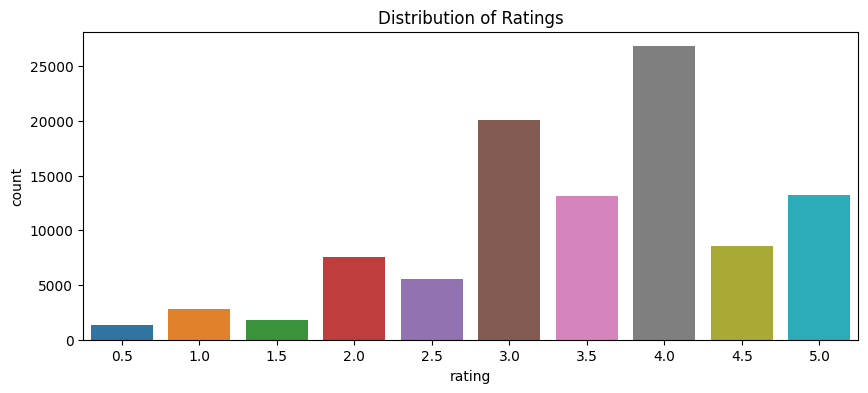

In [24]:
# Distribution of ratings
plt.figure(figsize=(10, 4))
sns.countplot(x="rating", data=ratings)
plt.title('Distribution of Ratings')
plt.show()

#### Top 10 movies with the most ratings

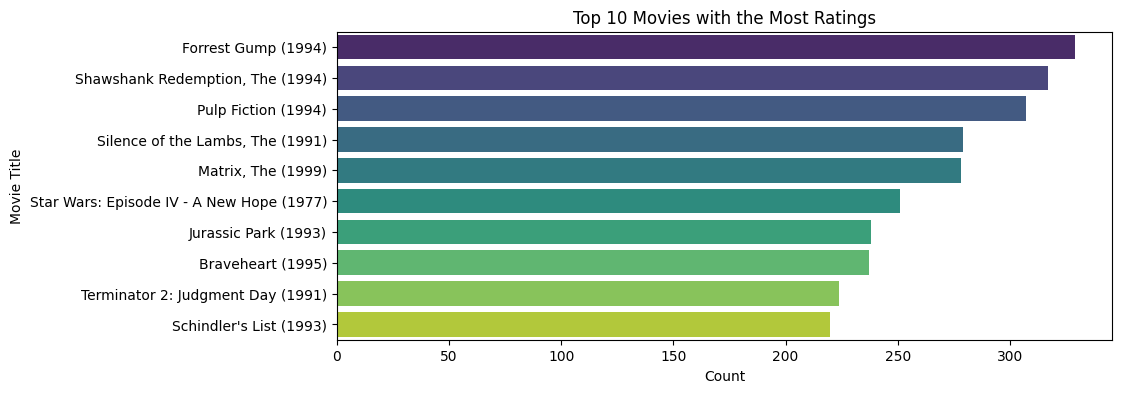

In [25]:
top_movies = ratings['movieId'].value_counts()[:10]
top_movies = pd.DataFrame({'movieId': top_movies.index, 'count': top_movies.values})
top_movies = pd.merge(top_movies, movies, on='movieId')

plt.figure(figsize=(10, 4))
sns.barplot(x='count', y='title', data=top_movies, palette='viridis')
plt.title('Top 10 Movies with the Most Ratings')
plt.xlabel('Count')
plt.ylabel('Movie Title')
plt.show()

### Feature Engineering

#### Feature Selection

In [27]:
# Import necessary libraries
from sklearn.feature_selection import SelectKBest, chi2

# Assuming that 'data' is your DataFrame and 'target' is the target variable
X = merged_ratings_df.drop('rating', axis=1)  # independent columns
y = merged_ratings_df['rating']  # target column

# Apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(X, y)

dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

# Concat two dataframes for better visualization
featureScores = pd.concat([dfcolumns, dfscores], axis=1)
featureScores.columns = ['Specs', 'rating']  # Naming the dataframe columns

# Print 10 best features
print(featureScores.nlargest(10, 'rating'))  

ValueError: could not convert string to float: 'Toy Story (1995)'

#### Feature Extraction

In [ ]:
# For a content recommendation system, the important features could be 'userId', 'movieId', and 'rating'.
# We will use these features to train our model.
features = ratings[['userId', 'movieId', 'rating']]

#### Feature Scaling

In [ ]:
# We will use MinMaxScaler to scale our features to a range of [0, 1].
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
features_scaled = pd.DataFrame(scaler.fit_transform(features), columns=features.columns)

#### Visualization of the selected features with pair plots

/home/praneeth/.local/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


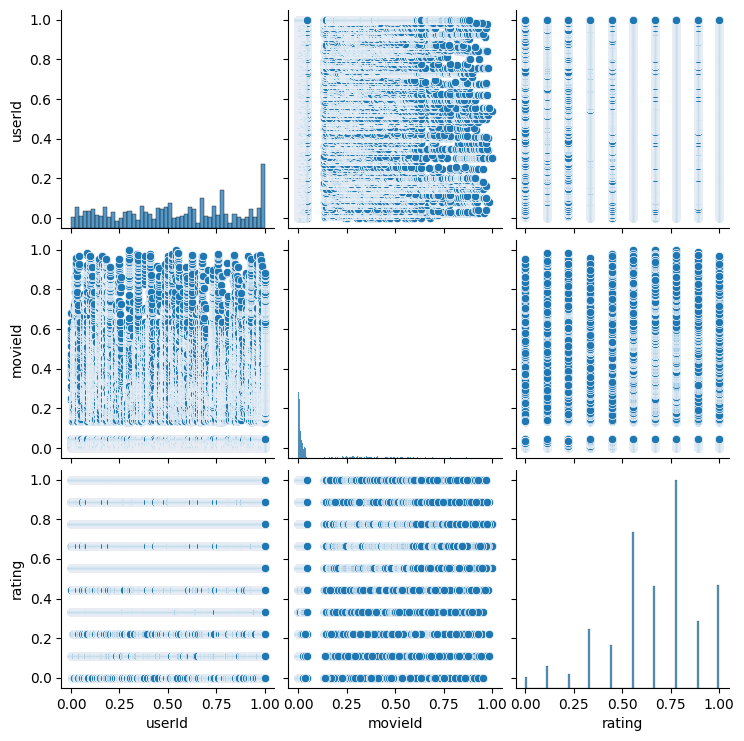

In [ ]:
sns.pairplot(features_scaled)
plt.show()

#### Correlation Matrix

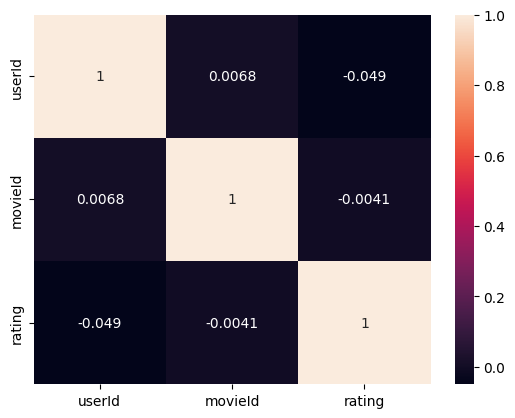

In [ ]:
correlation_matrix_scaled = features_scaled.corr()
sns.heatmap(correlation_matrix_scaled, annot=True)
plt.show()